Identifying humpback whale calls
======

This notebook explores data from the Pacific Ocean Sound Recordings (https://registry.opendata.aws/pacific-sound).  The data consists of daily audio files (wav) collected in deep water off by the coast of central California.  The analysis here extends upon an [existing notebook](https://docs.mbari.org/pacific-sound/notebooks/humpbackwhales/detect/PacificSoundDetectHumpbackSong/) from researchers at Monterrey Bay Aquarium Research Institute (MBARI).

In this analysis we'll apply a trained deep learning [model](https://tfhub.dev/google/humpback_whale/1) that identifies humpback whale calls (ref: A. Allen et al., "A convolutional neural network for automated detection of humpback whale song in a diverse, long-term passive acoustic dataset", Front. Mar. Sci., 2021, doi: 10.3389/fmars.2021.607321.)

To process the audio files, we'll make use of an orchestration framework called [redun](https://github.com/insitro/redun) that will facilitate running jobs locally and in AWS batch as well as caching outputs along with provinence.

This notebook explores the dataset.  The pipeline can be found in humpback_pipeline.py

### Load libraries
In addition, we'll load the previously downloaded model file.

In [1]:
import boto3
from datetime import datetime
import librosa
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import soundfile as sf

import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy

from botocore import UNSIGNED
from botocore.client import Config
from io import BytesIO

In [2]:
MODEL_URI = './humpback_model_cache'
model = hub.load(MODEL_URI)

2022-05-14 14:51:11.732068: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data loading method
Each audio file is several GB.  This would pull down quickly if you're running in AWS in the same region as the data (us-west-2) but is really tedious when running locally (e.g. this notebook on my laptop).  To speed things up a bit, we'll use byte offset downloads from s3 to pull in just the chunk of data we want.  However... the header is variable and is needed to parse metadata about the file.  So, we need to download from the start of the file to a buffered amount past where we expect the end of what we need is.  This clearly works best if you're looking at data from early in the day (UTC), so we'll do most of the testing in the first few hours.

In [3]:
def load_wav_by_date(
    year: int,
    month: int,
    day: int,
    hour: int = 0,
    minute: int = 0,
    duration_min: int = 60*12,
    sr: int = 16000,
    header_size: int = 1024,  # this is not exact, just a buffer
    bucket: str = "pacific-sound-16khz"
):
    assert (hour * 60 + minute + duration_min) <= (60*24)
    filename = f"MARS-{year}{month:02d}{day:02d}T000000Z-16kHz.wav"
    obj_path = f"{year}/{month:02d}/{filename}"
    start_ = sr * 60 * ((hour * 60) + (minute)) # samples
    duration_ = sr * 60 * duration_min
    end_ = start_ + duration_
    offset_start = header_size + start_ * 3  # 24bit
    read_bytes = duration_ * 3
    offset_end = offset_start + read_bytes
    s3cl = boto3.client(
        "s3",
        aws_access_key_id='',
        aws_secret_access_key='',
        config=Config(signature_version=UNSIGNED))
    s3_obj = s3cl.get_object(Bucket=bucket, 
                             Key=obj_path, 
                             Range=f"bytes=0-{offset_end}")  # need to read header
    sound_arr, _ = sf.read(BytesIO(s3_obj["Body"].read()), dtype='float32')
    return sound_arr[start_:end_]

### Set up methods to visualize audio data and model predictions
This is borrowed directly from the referenced notebook.

In [4]:
def plot_spectrogram_scipy(signal, sample_rate, 
                           hydrophone_sensitivity,
                           title=None,
                           with_colorbar=True
                           ):

    # Compute spectrogram:    
    w = scipy.signal.get_window('hann', sample_rate)
    f, t, psd = scipy.signal.spectrogram(signal, 
                                         sample_rate, 
                                         nperseg=sample_rate, 
                                         noverlap=0,
                                         window=w,
                                         nfft=sample_rate,
                                         )
    psd = 10*np.log10(psd) - hydrophone_sensitivity

    # Plot spectrogram:
    plt.imshow(psd, aspect='auto', origin='lower',
               vmin=30, vmax=90,
               cmap='Blues',
               )
    plt.yscale('log')
    y_max = sample_rate / 2
    plt.ylim(10, y_max)

    if with_colorbar:
        plt.colorbar()

    plt.xlabel('Seconds')
    plt.ylabel('Frequency (Hz)')
    plt.title(title or \
              f'Calibrated spectrum levels, 16 {sample_rate / 1000.0} kHz data')

    
def plot_scores(scores, 
                with_steps=False,
                with_dots=True,
                med_filt_size=None,
                ):

    if with_steps:
        # repeat last value to also see a step at the end:
        scores = np.concatenate((scores, scores[-1:]))
        x = range(len(scores))
        plt.step(x, scores, where='post')
    else:
        x = range(len(scores))

    if with_dots:
        plt.plot(x, scores, 'o', color='lightgrey', markersize=9)

    plt.grid(axis='x', color='0.95')
    plt.xlim(xmin=0, xmax=len(scores) - 1)
    plt.ylabel('Model Score')
    plt.xlabel('Seconds')

    if med_filt_size is not None:
        scores_int = [int(s*1000) for s in scores]
        meds_int = scipy.signal.medfilt(scores_int, kernel_size=med_filt_size)
        meds = [m/1000. for m in meds_int]
        plt.plot(x, meds, 'p', color='black', markersize=9)
    
def plot_results(scores,
                 context_step_samples,
                 signal,
                 sample_rate,
                 hydrophone_sensitivity,
                 title,
                 scores_with_dots=True,
                 scores_with_steps=False,
                 scores_med_filt_size=None,
                 ):

    signal_len_per_scores = len(scores) * context_step_samples 

    # Note, the nominal signal length per the obtained score array from the
    # model may be larger than the signal given as input.
    # When this happens, we discard as many trailing scores as necesary:
    while signal_len_per_scores > len(signal):
        scores = scores[:-1]
        signal_len_per_scores = len(scores) * context_step_samples
        # print(f':: adjusting: signal_len_per_scores = {signal_len_per_scores}')

    # A final adjustment to make scores and signal "aligned:"
    signal = signal[:signal_len_per_scores]

    # As numpy array:
    signal = np.array(signal)

    fig = plt.figure(figsize=(24, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

    # Plot spectrogram:
    plt.subplot(gs[0])
    plot_spectrogram_scipy(signal, sample_rate, hydrophone_sensitivity,
                           title,
                           with_colorbar=False,
                           )

    # Plot scores:
    fig.add_subplot(gs[1])
    plot_scores(scores, 
                with_dots=scores_with_dots,
                with_steps=scores_with_steps,
                med_filt_size=scores_med_filt_size,
                )

    plt.tight_layout()
    plt.show()


### Run model over a chunk of data

Let's load up a chunk of data used in the model used in the existing notebook which looks at a 30min window on Dec 21, 2016 starting at 0:25UTC (but let's pull an hour starting a 0:00 just for kicks).

In [5]:
year = 2016
month = 12
day = 21
hour = 0
minute = 0
duration_min = 60

%time raw = load_wav_by_date(year, month, day, hour, minute, duration_min)
print(raw.shape)

CPU times: user 1.9 s, sys: 2.42 s, total: 4.33 s
Wall time: 36.2 s
(57600000,)


The raw data has a sampling rate of 16kHz but the model is expecting 10kHz.  Let's resample that down.

In [6]:
%%time
resamp = librosa.resample(
    raw, 
    orig_sr=16000,
    target_sr=10000,
    scale=True  # Scale the resampled signal so that y and y_hat have approximately equal total energy
)
print(raw.shape)

(57600000,)
CPU times: user 1min 11s, sys: 1.09 s, total: 1min 12s
Wall time: 1min 16s


The tensorflow model requires a little preprocessing to reshape the data into the expected Tensor array size.

In [7]:
waveform = np.expand_dims(resamp, axis=1)
waveform_exp = tf.expand_dims(waveform, 0)  # makes a batch of size 1
print(waveform_exp.shape)

(1, 36000000, 1)


The model will automatically run a "front_end" transformation, which creates a PCEN normalized spectrogram.  The model takes a ~3.9s window for each prediction and we can specify the context window in units of samples to output predictions at the specified interval.  We will use a 1s window.

In [8]:
%%time
context_step_samples = tf.cast(10000, tf.int64)  # 1 sec context window
score_fn = model.signatures['score']
scores = score_fn(waveform=waveform_exp, context_step_samples=context_step_samples)
score_values = scores['scores'].numpy()[0]
print(score_values.shape)

(3633, 1)
CPU times: user 11min 29s, sys: 4min 56s, total: 16min 26s
Wall time: 9min 43s


/var/folders/34/5388gb592mz9tq_czxh1j_9h0000gn/T/ipykernel_15840/3329448851.py:16: RuntimeWarning: divide by zero encountered in log10
  psd = 10*np.log10(psd) - hydrophone_sensitivity


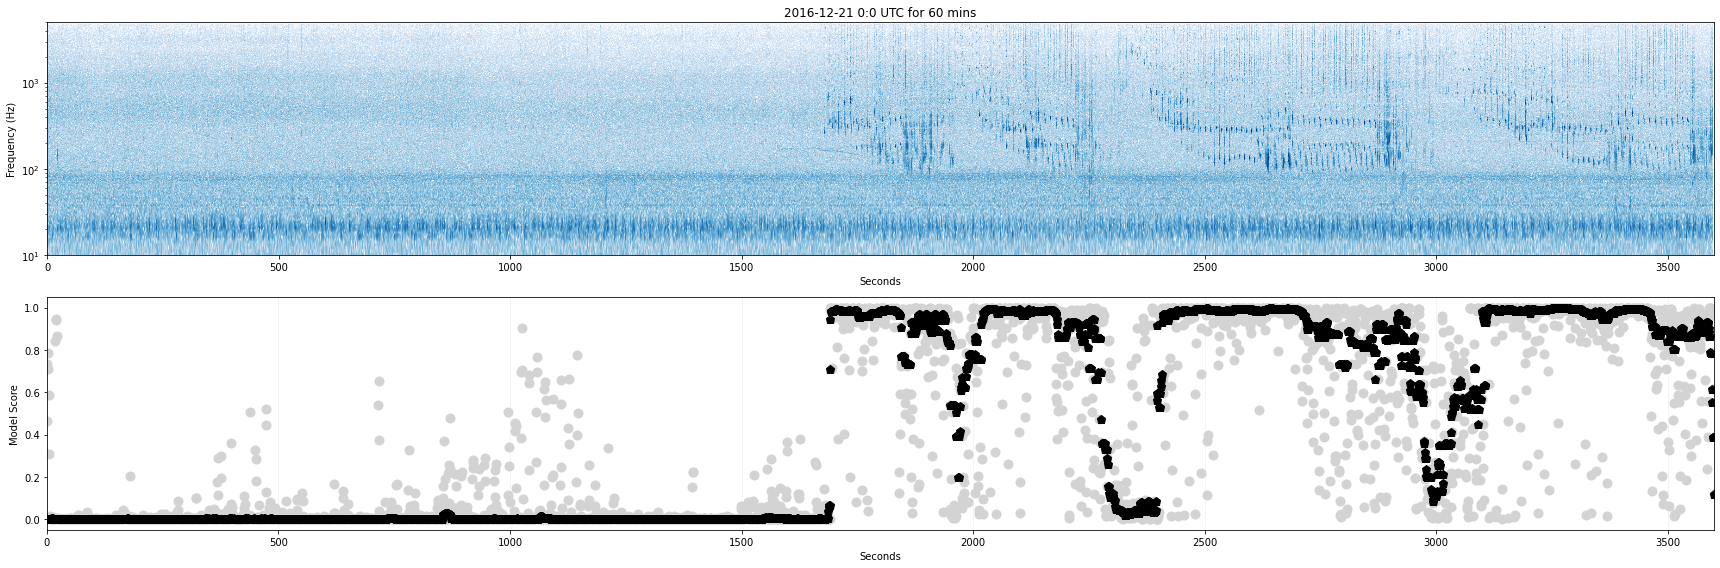

In [9]:
plot_results(score_values,
         context_step_samples,
         signal=resamp,
         sample_rate=10000,
         hydrophone_sensitivity=-168.8,
         title=f"{year}-{month:02d}-{day:02d} {hour}:{minute} UTC for {duration_min} mins",
         scores_with_dots=True,
         scores_med_filt_size=25,
        )

That took a fair bit of time and consumed a ton of RAM (>15GB) while evaluating the model. I'd rather not pay for a massive machine with ton of RAM when running in the cloud, so let's see if we can reduce the memory utilization (to be fair, this is probably fine if I could figure out how to properly run this on a GPU).

The scoring method must be either trying to parallelize with a bunch of data copies or trying to utilize linear algebra methods working with the large input array on the trained network.  Either way, we're going to hit some CPU bottlenecks so this degree of parallelization/optimization is likely counter productive.  Let's just try running the pre-processing on the entire dataset, then running predictions in series on each context window.

First, we get the PCEN normalized spectrum.

In [10]:
%time pcen_spectrogram = model.front_end(waveform_exp)
print(pcen_spectrogram.shape)

CPU times: user 13.9 s, sys: 2.51 s, total: 16.4 s
Wall time: 12.8 s
(1, 119997, 64)


It looks like it has 64 bands in the frequency space and the sfft bins are 33.3ms, so we're going to need to do some math to get the right context window size.  Let's see what this things looks like.

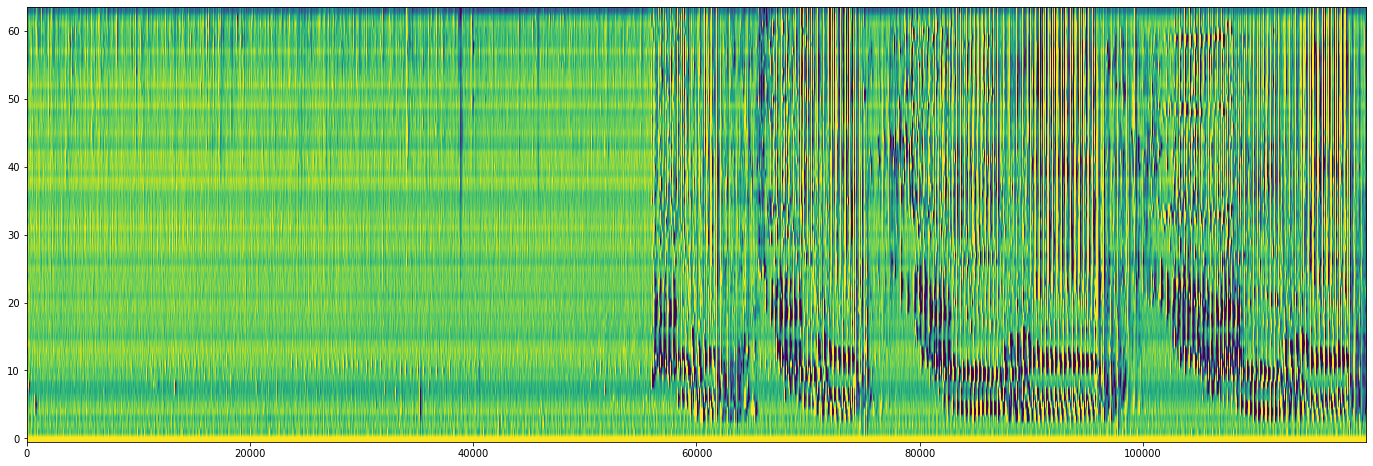

In [11]:
plt.figure(figsize=(24, 8))
plt.imshow(pcen_spectrogram.numpy()[0,:, :].T, 
           aspect='auto', 
           origin='lower', 
           vmin=0.1, vmax=.3)

A bit different from the non-normalized spectrogram but clearly highlighting call features.  Seems we lose most of the low frequency data.  So probably not a useful intermediate for something like blue or fin whale calls, but might be useful for models where features are above 100Hz.

Now let's try applying the fit to 1s windows and making sure we get roughly the same output.

In [17]:
def fit_window(i):
    start = int((119997 * i / 3600))
    end = start + 128
    if end > pcen_spectrogram.shape[1]:  # the last few secs will be 0
        return 0
    context_window = pcen_spectrogram[:, start:end, :]
    features = model.features(context_window)
    logits = model.logits(context_window)
    probabilities = tf.nn.sigmoid(logits)
    return probabilities.numpy()[0][0]

%time scores_v2 = list(map(fit_window, range(3600)))

CPU times: user 29min 9s, sys: 1min 30s, total: 30min 40s
Wall time: 12min 1s


About the same wall time but memory usage was negligable.  Do they look the same?

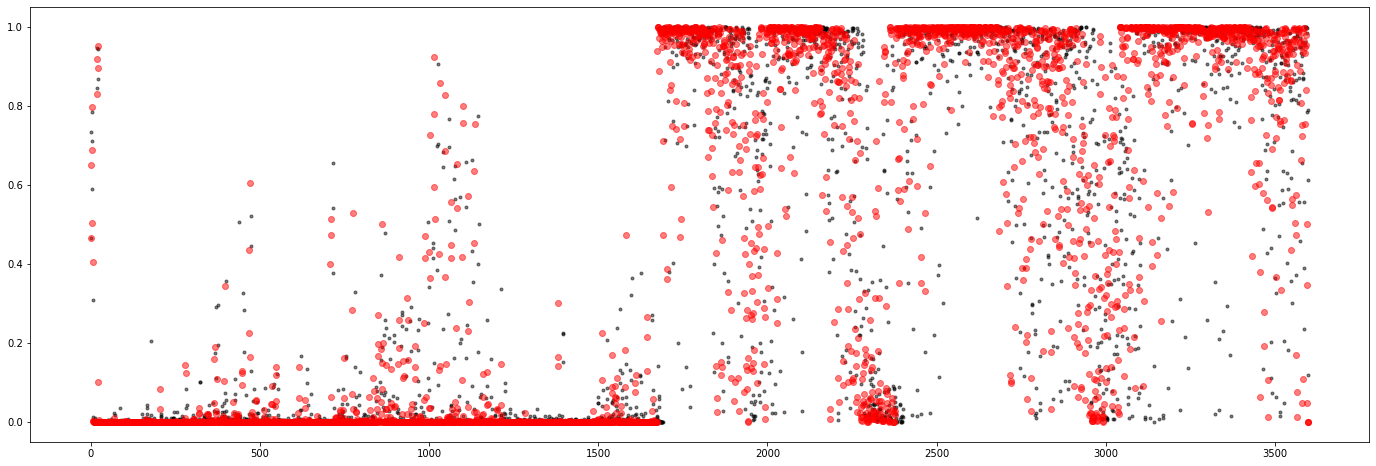

In [18]:
plt.figure(figsize=(24, 8))
plt.plot(score_values[:3600], 'k.', alpha=0.5)
plt.plot(np.array(scores_v2), 'ro', alpha=0.5)

Some slight offsets, but good enough for me. The score_values array from the original fit is longer than the original sample anyway.

Now we have all the pieces to build a pipeline to process larger chunks of time.